In [1]:
import enum
import math

import matplotlib.pyplot as plt


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from itertools import chain

import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
import copy
from torch.utils.data import DataLoader, Dataset
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

# #show if metal is available
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")
    
# # show python version
# !python -V

# torch.set_default_dtype(torch.float32)

2.1.1
11.8


## collecting and preparing data

In [3]:
%pwd

'/home/alinezhad.f'

In [4]:
#change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/cancer')

# Cancer data preparation

In [5]:
#read from pickle file
training_data = pd.read_pickle('training_data.pkl')
validation_data = pd.read_pickle('validation_data.pkl')

test_data_factuals = pd.read_pickle('test_data_factuals.pkl')
#:return: simulated data dict with number of rows equal to num_patients * seq_length * num_treatments
test_data_counterfactuals = pd.read_pickle('test_data_counterfactuals.pkl')
#:return: simulated data dict with number of rows equal to num_patients * seq_length * 2 * projection_horizon
test_data_seq = pd.read_pickle('test_data_seq.pkl')
means = pd.read_pickle('means.pkl')
stds = pd.read_pickle('stds.pkl')

In [6]:
#scale the data
for key in training_data.keys():
    if key in means.keys():
        training_data[key] = (training_data[key] - means[key]) / stds[key]
        validation_data[key] = (validation_data[key] - means[key]) / stds[key]
        test_data_factuals[key] = (test_data_factuals[key] - means[key]) / stds[key]

for key in test_data_counterfactuals.keys():
    if key in means.keys():
        test_data_counterfactuals[key] = (test_data_counterfactuals[key] - means[key]) / stds[key]
        test_data_seq[key] = (test_data_seq[key] - means[key]) / stds[key]

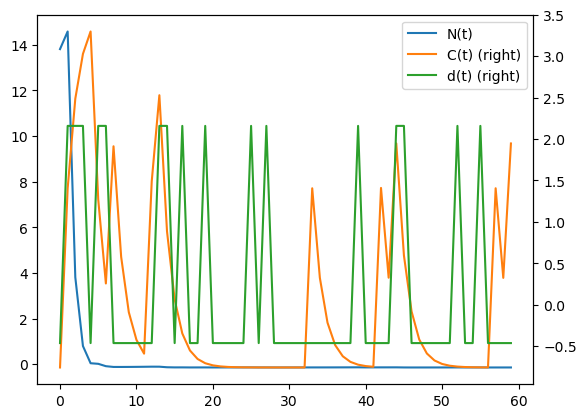

In [7]:
def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_dosage'][patient],
                       'd(t)': data['radio_dosage'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()

plot_treatments(test_data_factuals, 130)

In [8]:
test_data_counterfactuals.keys()

dict_keys(['cancer_volume', 'chemo_application', 'radio_application', 'sequence_lengths', 'patient_types'])

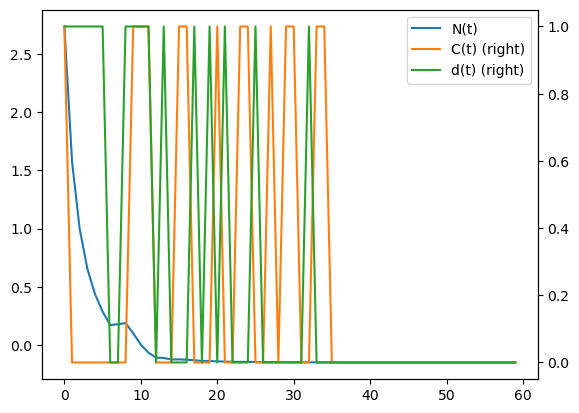

In [9]:
def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_application'][patient],
                       'd(t)': data['radio_application'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()

plot_treatments(test_data_counterfactuals, 34000)

In [10]:
training_data.keys()

dict_keys(['cancer_volume', 'chemo_dosage', 'radio_dosage', 'chemo_application', 'radio_application', 'chemo_probabilities', 'radio_probabilities', 'sequence_lengths', 'death_flags', 'recovery_flags', 'patient_types'])

In [11]:
# add a column that indicates the application of chemo and radio at time t-1

def add_previous_treatment(data: dict):
    data['chemo_application_prev'] = np.roll(data['chemo_application'], 1, axis=1)
    data['radio_application_prev'] = np.roll(data['radio_application'], 1, axis=1)
    data['chemo_application_prev'][:, 0] = 0
    data['radio_application_prev'][:, 0] = 0
    return data

training_data = add_previous_treatment(training_data)
validation_data = add_previous_treatment(validation_data)
test_data_factuals = add_previous_treatment(test_data_factuals)
test_data_counterfactuals = add_previous_treatment(test_data_counterfactuals)
test_data_seq = add_previous_treatment(test_data_seq)

def add_time_steps(data: dict): # this should be the same shape as the cancer_volume (patients, time_steps)
    data['time_step'] = np.tile(np.arange(data['cancer_volume'].shape[1]), (data['cancer_volume'].shape[0], 1))
    return data

#sequence lengths is reported once per patient, so we tile it to match the shape of the data
def add_sequence_lengths(data: dict):
    data['sequence_length_tile'] = np.tile(data['sequence_lengths'][:, None], (1, data['cancer_volume'].shape[1]))
    data['distance_from_end'] = data['sequence_length_tile'] - data['time_step']
    #distance_from_end_scaled is a value between 0 and 1 that indicates how far we are from the end of the sequence for each patient
    data['distance_from_end_scaled'] = data['distance_from_end'] / data['sequence_length_tile']
    return data

training_data = add_time_steps(training_data)
validation_data = add_time_steps(validation_data)
test_data_factuals = add_time_steps(test_data_factuals)
test_data_counterfactuals = add_time_steps(test_data_counterfactuals)
test_data_seq = add_time_steps(test_data_seq)

training_data = add_sequence_lengths(training_data)
validation_data = add_sequence_lengths(validation_data)
test_data_factuals = add_sequence_lengths(test_data_factuals)
test_data_counterfactuals = add_sequence_lengths(test_data_counterfactuals)
test_data_seq = add_sequence_lengths(test_data_seq)

In [12]:
training_data['time_step'].shape
training_data['sequence_length_tile'].shape
training_data['chemo_application_prev'].shape

(10000, 60)

(10000, 60)

(10000, 60)

In [13]:
training_data_sequence_lengths = training_data['sequence_lengths']
validation_data_sequence_lengths = validation_data['sequence_lengths']
test_data_factuals_sequence_lengths = test_data_factuals['sequence_lengths']
test_data_counterfactuals_sequence_lengths = test_data_counterfactuals['sequence_lengths']
test_data_seq_sequence_lengths = test_data_seq['sequence_lengths']

In [14]:
#count of the unique values of the sequence lengths
np.unique(training_data_sequence_lengths, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 17., 18., 19., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 31., 32., 33., 35., 37., 40., 42., 43., 45., 48., 50., 52.,
        53., 57., 58., 59.]),
 array([  15,   98,   69,   37,   19,   21,   15,    9,    7,    6,    6,
           7,    6,    2,    4,    6,    1,    2,    1,    1,    3,    1,
           2,    1,    1,    1,    1,    1,    1,    1,    1,    2,    1,
           1,    1,    1,    2,    1,    1,    3,    2,    1, 9638]))

In [15]:
np.unique(test_data_counterfactuals_sequence_lengths, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., 55., 56., 57., 58., 59.]),
 array([4000, 3964, 3948, 3936, 3912, 3904, 3904, 3888, 3880, 3876, 3876,
        3876, 3868, 3868, 3864, 3860, 3852, 3852, 3852, 3848, 3848, 3844,
        3844, 3836, 3820, 3820, 3816, 3816, 3804, 3804, 3804, 3800, 3800,
        3800, 3796, 3792, 3784, 3780, 3780, 3772, 3772, 3772, 3772, 3772,
        3772, 3772, 3772, 3772, 3764, 3764, 3764, 3760, 3752, 3752, 3752,
        3748, 3748, 3744, 3744]))

In [16]:
needed_keys = [
    'chemo_application_prev', 'radio_application_prev', 'cancer_volume'
]

training_data = {key: training_data[key] for key in needed_keys}
validation_data = {key: validation_data[key] for key in needed_keys}
test_data_factuals = {key: test_data_factuals[key] for key in needed_keys}
test_data_counterfactuals = {key: test_data_counterfactuals[key] for key in needed_keys}
test_data_seq = {key: test_data_seq[key] for key in needed_keys}

In [17]:
#convert tensors where the first dimension is the number of patients the second dimension is time and the third is the features
#the keys are the features
#within the features, the first dimension is the number of patients, the second is time

#convert the keys to a dimension in the tensor
def dictionary_to_tensor(data_dict):
    # Extract keys and values from the dictionary
    keys = list(data_dict.keys())
    values = [data_dict[key] for key in keys]
    
    # Check consistency in dimensions
    num_patients = values[0].shape[0]
    time_steps = values[0].shape[1]
    
    for table in values:
        assert table.shape[0] == num_patients, "Number of patients mismatch."
        assert table.shape[1] == time_steps, "Number of time steps mismatch."
    
    # Stack tables along the new feature dimension
    tensor = np.stack(values, axis=-1)
    tensor = torch.tensor(tensor, dtype=torch.float32)
    
    return tensor, keys
    
training_data_tensor, keys = dictionary_to_tensor(training_data)
validation_data_tensor, keys = dictionary_to_tensor(validation_data)
test_data_factuals_tensor, keys = dictionary_to_tensor(test_data_factuals)
test_data_counterfactuals_tensor, keys = dictionary_to_tensor(test_data_counterfactuals)
test_data_seq_tensor, keys = dictionary_to_tensor(test_data_seq)

In [18]:
test_data_counterfactuals_tensor.shape
test_data_seq_tensor.shape

torch.Size([225456, 60, 3])

torch.Size([570680, 65, 3])

In [19]:
test_data_counterfactuals_sequence_lengths.shape
test_data_seq_sequence_lengths.shape

(225456,)

(570680,)

## Data embedding before feeding into the model

This will first one-hot encode all the categorical features and then embed them to n columns. The resulting columns will then be concatenated with the numerical features. The result will then be used to create the torch tensor for the model. The torch tensor will be shaped as (Cases, Time, Features).

The input data will be a dataframe like this:





In [20]:
class DataEmbedder(nn.Module):
    def __init__(self, categorical_indices_sizes, numerical_indices, dataset):
        super(DataEmbedder, self).__init__()
        self.categoricals = categorical_indices_sizes #dictionary with feature name, and a list of index and size
        self.numerics = numerical_indices #dictionary with feature name and index
        self.embeddings = nn.ModuleDict()
        self.mapping_dicts = {}

        # Initialize embeddings and mapping dictionaries
        for key in self.categoricals:
            unique_values = np.unique(dataset[:, :, self.categoricals[key][0]])
            self.mapping_dicts[key] = {name: idx for idx, name in enumerate(unique_values)}
            self.embeddings[key] = nn.Embedding(num_embeddings=len(unique_values), embedding_dim=self.categoricals[key][1])
            print(f"Feature: {key}, Categories: {len(unique_values)}, Embedding Size: {self.categoricals[key][1]}")
    
    def forward(self, dataset):

        # Apply embeddings to the categorical indices
        embedded_features = []
        for key in self.categoricals:
            embedded_features.append(self.embeddings[key](dataset[:, :, self.categoricals[key][0]].long()))
        
        
        embedded_features = torch.cat(embedded_features, dim=-1)

        numeric_features = dataset[:, :, list(self.numerics.values())].float()

        # Concatenate the embedded features with the numerical data
        result = torch.cat([embedded_features, numeric_features], dim=-1)

        feature_count_embedded = len(self.numerics) + sum([self.categoricals[key][1] for key in self.categoricals])

        result = result.reshape(dataset.shape[0], -1, feature_count_embedded)

        return result



# Transformer

## Moded Transformer

In [21]:
class moded_TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(moded_TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)#(self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)#, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4)#, 5) # BxHxTxFxDxD


        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)


        #softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b*h, t*f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfd->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [22]:
class moded_TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoderCell, self).__init__()

        self.time_series_attention = moded_TimesSeriesAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention2 = self.time_series_attention(x, x, x, mask)
        attention = x + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(
            self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention


In [23]:
class moded_TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float = 0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(moded_TransformerEncoderCell(
            embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y


## RSA

In [24]:
class TimesSeriesAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_out,
        nh=8,
        dk=0,
        dv=0,
        dd=0,
        kernel_size=(3, 7),
        stride=(1,1,1),
        kernel_type='VplusR',  # ['V', 'R', 'VplusR']
        feat_type='VplusR',  # ['V', 'R', 'VplusR']
    ):
        super(TimesSeriesAttention, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.nh = nh
        self.dv = dv = d_out // nh if dv == 0 else dv
        self.dk = dk = dv if dk == 0 else dk
        self.dd = dd = dk if dd == 0 else dd

        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_type = kernel_type
        self.feat_type = feat_type

        assert self.kernel_type in [
            'V', 'R', 'VplusR'], "Not implemented involution type: {}".format(self.kernel_type)
        assert self.feat_type in [
            'V', 'R', 'VplusR'], "Not implemented feature type: {}".format(self.feat_type)

        # print("d_in: {}, d_out: {}, nh: {}, dk: {}, dv: {}, dd:{}, kernel_size: {}, kernel_type: {}, feat_type: {}"
        #       .format(d_in, d_out, nh, dk, dv, self.dd, kernel_size, kernel_type, feat_type))

        self.ksize = ksize = kernel_size[0] * kernel_size[1]
        self.pad = pad = tuple(k//2 for k in kernel_size)

        # hidden dimension
        d_hid = nh * dk + dv if self.kernel_type == 'V' else nh * dk + dk + dv

        # Linear projection
        #self.projection = nn.Conv2d(d_in, d_hid, 1, bias=False)
        self.projection_linear = nn.Sequential(
            nn.Linear(d_in, d_hid, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(d_hid, d_hid, bias=False)
        )

        # Intervolution Kernel
        if self.kernel_type == 'V':
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'R':
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'VplusR':
            self.P1 = nn.Parameter(torch.randn(dk, dd).unsqueeze(
                0)*np.sqrt(1/(ksize*dd)), requires_grad=True)
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        else:
            raise NotImplementedError

        # Feature embedding layer
        if self.feat_type == 'V':
            pass
        elif self.feat_type == 'R':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
        elif self.feat_type == 'VplusR':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
            self.I = nn.Parameter(torch.eye(dk).unsqueeze(0), requires_grad=True)
        else:
            raise NotImplementedError

        # Downsampling layer
        if max(self.stride) > 1:
            self.avgpool = nn.AvgPool2d(kernel_size=(
                1, 3), stride=(1, 2), padding=(0, 1))

    def L2norm(self, x, d=1):
        eps = 1e-6
        norm = x ** 2
        norm = norm.sum(dim=d, keepdim=True) + eps
        norm = norm ** (0.5)
        return (x / norm)

    def forward(self, x):
                
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        N, C, T, H= x.shape

        x = x.permute(0, 2, 3, 1)
        
        '''Linear projection'''
        #x_proj = self.projection(x)
        x_proj = self.projection_linear(x)
        x_proj = x_proj.permute(0, 3, 1, 2)
        #print(x_proj.shape)

        if self.kernel_type != 'V':
            q, k, v = torch.split(
                x_proj, [self.nh * self.dk, self.dk, self.dv], dim=1)
        else:
            q, v = torch.split(x_proj, [self.nh * self.dk, self.dv], dim=1)

        '''Normalization'''
        q = rearrange(q, 'b (nh k) t h -> b nh k t h', k=self.dk)
        q = self.L2norm(q, d=2)
        q = rearrange(q, 'b nh k t h -> (b t h) nh k')

        v = self.L2norm(v, d=1)

        if self.kernel_type != 'V':
            k = self.L2norm(k, d=1)

        '''
        q = (b t h) nh k
        k = b k t h
        v = b v t h
        '''

        #Intervolution generation
        # Basic kernel
        if self.kernel_type == 'V':
            kernel = q
        # Relational kernel
        else:
            K_H1 = self.H1(k)
            K_H1 = rearrange(K_H1, 'b (k d) t h-> (b t h) k d', k=self.dk)

            if self.kernel_type == 'VplusR':
                K_H1 = K_H1 + self.P1

            kernel = torch.einsum(
                'abc,abd->acd', q.transpose(1, 2), K_H1)  # (bth, nh, d)

        #feature generation
        # Appearance feature
        v = rearrange(v, 'b (v 1) t h-> (b v) 1 t h')

        V = self.H2(v)  # (bv, d, t, h)
        feature = rearrange(V, '(b v) d t h -> (b t h) v d', v=self.dv)

        # Relational feature
        if self.feat_type in ['R', 'VplusR']:
            V_G = self.G(v)  # (bv, v2, t, h)
            V_G = rearrange(V_G, '(b v) v2 t h -> (b t h) v v2', v=self.dv)

            if self.feat_type == 'VplusR':
                V_G = V_G + self.I

            feature = torch.einsum('abc,abd->acd', V_G, feature)  # (bth, v2, d)

        #kernel * feat
        out = torch.einsum('abc,adc->adb', kernel, feature)  # (bth, nh, v2)

        out = rearrange(out, '(b t h) nh v -> b (nh v) t h', t=T, h=H)

        if max(self.stride) > 1:
            out = self.avgpool(out)

        out = out.permute(0, 2, 3, 1)

        return out


In [25]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, embed_dim, nh = num_heads, kernel_size=kernel_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)


    def forward(self, data: torch.Tensor,embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        #attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [26]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, kernel_size, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## CSDI transformer

In [27]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, activation="gelu", dropout=dropout
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings

In [28]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(2).repeat((1,1,f,1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe
        
        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(1).repeat((1,l,1,1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block

In [29]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, num_heads=8, num_cells=1, kernel_size=(3, 7), embed_dim=128, ff_dim=512, dropout=0.1, method = "rsa"):
        super().__init__()

        self.method = method

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim*4, embed_dim*4),
            nn.SiLU(),
            nn.Linear(embed_dim*4, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        


        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        if method == "rsa":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            
        elif method == "csdi":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "csdi_moded_transformer":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "rsa_csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        
        elif method == "rsa_moded_transformer":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "moded_transformer_alone":
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        else:
            raise NotImplementedError


        
        
    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y        


    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):

        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape
        
        y = torch.stack((noised_data, diffusion_emb, time_emb, feature_emb), dim = -1)
        y = y.reshape(b, t, f, -1)
        y = self.embedding_add(y)
        y_resid = y

        if self.method == "rsa":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
        
        elif self.method == "csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_moded_transformer":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)
        
        elif self.method == "moded_transformer_alone":
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)

        
        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t*f)
        y = self.mid_projection(y)
        #y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        #y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        #y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [31]:
class ModelLoop(nn.Module):
    def __init__(self, embed_dim=128, diffusion_steps = 1000, num_heads=8, kernel_size=(3, 7),num_cells=1, num_residual_layers = 4, ff_dim=512, dropout=0.1, method = "rsa", device = "cpu"):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)
        
        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)
        
        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
                ResidualBlock(
                    num_heads=num_heads,
                    num_cells=num_cells,
                    kernel_size=kernel_size,
                    embed_dim=embed_dim,
                    ff_dim=ff_dim,
                    dropout=dropout,
                    method = method
                ) for _ in range(num_residual_layers)
        )
    
        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )


    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape
        
        noised_data_reshaped = noised_data.permute(0, 3, 1, 2).reshape(b, 1, t*f)
        noised_data_embedded = self.data_embedding_linear(noised_data_reshaped).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data_embedded, device = self.device)
        time_embedding = self.time_embedding(noised_data_embedded, device = self.device)
        feature_embedding = self.feature_embedding(noised_data_embedded, device = self.device)

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_embedding, time_embedding, feature_embedding)
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim = -1)
            #x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t*f)
            x = self.x_embedding(x).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim = -1), dim=-1)/ math.sqrt(len(self.residual_layers))
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        #x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
        x = self.output_final(x).permute(0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules

In [32]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return torch.linspace(
            beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps
        ) ** 2

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer

In [33]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim, excluded_features = None,
                #vocab_size,
                #pad_idx= None,
                strategy = "random",
                num_residual_layers = 4,
                features_to_impute = None,
                features_to_impute_completely = None,
                features_to_impute_after_time = None,
                last_n_time = 1,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "quadratic",
                num_heads = 8,
                kernel_size=(3, 7),
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                method = "rsa",
                device = "cpu"):
        
        super().__init__()

    
        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time
        self.exclude_features = excluded_features   
        self.features_to_impute_completely = features_to_impute_completely
        self.features_to_impute_after_time = features_to_impute_after_time

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        
        self.model_loop = ModelLoop(embed_dim = self.emb_dim,
                                    diffusion_steps = diffusion_steps,
                                    num_heads = num_heads,
                                    kernel_size = kernel_size,
                                    ff_dim = ff_dim,
                                    num_cells = num_cells,
                                    dropout = dropout,
                                    num_residual_layers = num_residual_layers,
                                    method = method,
                                    device = self.device)
        
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def get_mask(self, data, strategy = "random"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            #death is the last 7 columns of the data
            mask[:,:, -1] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()

        if strategy == "selected_features_and_selected_features_after_time":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute_completely] = 1
            mask[:, -self.last_n_time:, self.features_to_impute_after_time] = 1

        if self.exclude_features is not None:
            mask[:, :, self.exclude_features] = 0

        return mask
    
    def loss_func(self, predicted_noise, noise, noise_mask):
        # noise = torch.nan_to_num(noise, nan=0.0)
        # predicted_noise = torch.nan_to_num(predicted_noise, nan=0.0)
        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data):
         
        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha)**0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)
    
    def eval_with_grad(self, data, scale=1):

        #with torch.no_grad():
        imputation_mask = self.get_mask(data, self.strategy).to(self.device)
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask * scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        for t in range(self.diffusion_steps - 1, -1, -1):

            x = x.unsqueeze(3).float()
            predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
            predicted_noise = predicted_noise * imputation_mask
            
            coeff1 = 1 / self.alpha_hat[t] ** 0.5
            coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
            
            x = x.squeeze(3)
            x = coeff1 * (x - coeff2 * predicted_noise)
            
            if t > 0:
                noise = torch.randn_like(x)
                sigma = (
                    (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                ) ** 0.5
                x += sigma * noise
            
            x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            
            imputed_samples = x

        return(imputed_samples, data, imputation_mask)

    
    def eval(self, data, imputation_mask, mean, std, scale=1 , verbose = True):
        
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask *scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
                predicted_noise = predicted_noise * imputation_mask
                
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            

            imputed_samples = x.detach()
        #show the data at torch.max(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))
        # print("differences = ", torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))
        # print("data = ", data[imputation_mask !=0])
        # print("imputed = ", imputed_samples[imputation_mask !=0])
        print("max difference = ", torch.max(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item())
        print("data at max difference = ", data[imputation_mask !=0][torch.argmax(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))].item())
        print("imputed at max difference = ", imputed_samples[imputation_mask !=0][torch.argmax(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))].item())
        mae = torch.mean(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item()
        #descale the data
        imputed_samples_copy = imputed_samples.detach().clone()
        imputed_samples_copy = imputed_samples_copy * std + mean
        data_copy = data.detach().clone()
        data_copy = data_copy * std + mean
        rmse = torch.sqrt(torch.mean((data_copy[imputation_mask !=0] - imputed_samples_copy[imputation_mask !=0])**2)).item()
        rmse = rmse / 1150 * 100
        if verbose == True:
            print("mae = ", mae)
            print("rmse = ", rmse)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return(imputed_samples, data, imputation_mask, mae, rmse)

# Training

In [34]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics
from itertools import chain
import numpy as np
from collections import deque

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder,
          windowed_mode=False, window_mode="uniform", min_window=50, max_window=100, neg_bin_p=0.95, train_on_all_every=4,
          annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
          device="cuda", verbose=False, plot_every=10,
          validation_frequency=1, validation_prp=10, moving_avg_window=10):
    
    batch_embedder = batch_embedder.to(device)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(
        chain(batch_embedder.parameters(), model.parameters()),
        lr=lr
    )

    model.train()
    batch_embedder.train()
    loss_list = []
    initial_value = 1.0  # Initial value for equal probability
    window_losses = torch.ones(max_window - min_window + 1, device=device) * initial_value  # Track losses for each window length
    window_counts = torch.zeros(max_window - min_window + 1, device=device)  # Track counts for each window length
    loss_deques = [deque(maxlen=moving_avg_window) for _ in range(max_window - min_window + 1)]  # Deques for moving average
    if windowed_mode and window_mode == "biased_loss":
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    epoch_loss_list = []
    val_loss = 0

    for epoch in range(epochs):
        # Annealing for the learning rate
        if annealing_mode and epoch > annealing_window:
            if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
                for g in optimizer.param_groups:
                    if g['lr'] * annealing_ratio < annealing_minimum:
                        g['lr'] = annealing_minimum
                    else:
                        g['lr'] *= annealing_ratio

        start = time.time()
        for i, batch in enumerate(data_loader):
            
            batch = batch.to(device)
            batch = batch_embedder(batch)

            # cut_start = 0
            # cut_end = 0
            batch_length = batch.shape[1]

            # Windowed mode logic
            if windowed_mode:
                if window_mode == "uniform":
                    while True:
                        window_length = torch.randint(min_window, max_window + 1, (1,)).item()
                        cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
                        cut_end = cut_start + window_length
                        if min_window <= (cut_end - cut_start) <= max_window:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "negative_binomial":
                    total_count = 1
                    probs = neg_bin_p
                    distribution = torch.distributions.NegativeBinomial(total_count=total_count, probs=probs)
                    while True:
                        window_length = distribution.sample().item() + min_window
                        cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= max_window:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "biased_loss":
                    if torch.min(window_counts) < 2:
                        # Use uniform distribution until each length has been used at least twice
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    elif torch.sum(window_counts) % train_on_all_every == 0:
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    else:
                        # Update probabilities based on moving average of losses
                        avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device)
                        window_probs = avg_losses / avg_losses.sum()
                    
                    while True:
                        window_length = torch.multinomial(window_probs, 1).item() + min_window
                        cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= max_window:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                    window_counts[window_length - min_window] += 1  # Update window counts

            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch)
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

            epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
            epoch_loss_list.append(epoch_loss)
            
            # Update window losses and moving average deque
            if windowed_mode and window_mode == "biased_loss":
                window_idx = window_length - min_window
                window_losses[window_idx] += loss.item()
                loss_deques[window_idx].append(loss.item())

            # Dynamic plot update
            if i % plot_every == 0:
                ax1.clear()
                ax1.set_ylim(0, 1)
                ax1.plot(loss_list)
                if len(loss_list) > 100:
                    ax1.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    ax1.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                            str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                if len(epoch_loss_list) > 0:
                    ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
                # ax1.text(0.1, 0.8, f"Learning rate: {optimizer.param_groups[0]['lr']:.4e}")
                ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}")
                ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s")
                ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min")
                if windowed_mode and window_mode == "biased_loss":
                    ax2.clear()
                    ax2.bar(range(min_window, max_window + 1), window_counts.cpu().numpy())
                    ax2.set_ylabel("Counts")
                    ax2.set_title("Counts of Each Window Length Used")

                    moving_avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device).cpu().numpy()
                    ax3.clear()
                    ax3.bar(range(min_window, max_window + 1), moving_avg_losses)
                    ax3.set_xlabel("Window Length")
                    ax3.set_ylabel("Moving Average Loss")
                    ax3.set_title("Moving Average Loss for Each Window Length")

                display(fig)
                clear_output(wait=True)

        end = time.time()

        # Validation
        if epoch % validation_frequency == 0:
            loss_list_validation = []
            for i, batch in enumerate(data_loader_validation):
                batch = batch.to(device)
                batch = batch_embedder(batch)
                if i % validation_prp == 0:
                    predicted_noise, noise, noise_mask = model(batch)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)

        if verbose:
            print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
            print(f"Validation Loss: {val_loss}")


    return model, loss_list


In [35]:
categorical_indices_sizes = {
    # 'time_step' : [0, 1],
    'chemo_application_prev': [0, 1],
    'radio_application_prev': [1, 1]
}

numerical_indices = {
    'cancer_volume': 2
}

# training_data_tensor_embedded = data_embedder(training_data_tensor)
# validation_data_tensor_embedded = data_embedder(validation_data_tensor)
# test_data_factuals_tensor_embedded = data_embedder(test_data_factuals_tensor)
# test_data_counterfactuals_tensor_embedded = data_embedder(test_data_counterfactuals_tensor)
# test_data_seq_tensor_embedded = data_embedder(test_data_seq_tensor)

In [36]:
#create data loader for train, val, and test 
train_loader = torch.utils.data.DataLoader(training_data_tensor, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data_tensor, batch_size=20, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data_counterfactuals_tensor, batch_size=20, shuffle=True)

#check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))
# print(len(test_loader))

500
50


In [37]:
import gc
torch.cuda.empty_cache()
gc.collect()

13268

In [42]:
diffusion_imputer = diffusion_imputation(emb_dim = 64,
                                        # strategy='forecasting_last_n_time',
                                        # strategy='random',
                                        # missing_prp= 0.1,
                                        # strategy='selected_features',
                                        strategy='selected_features_last_n_time',
                                        features_to_impute = [2],
                                        # excluded_features = [i for i in range(6)], #[2],#[0,1,2,3,5], #for the embedded stock names which we don't need to predict
                                        # strategy='selected_features_and_selected_features_after_time',
                                        # features_to_impute_completely=[2],
                                        # features_to_impute_after_time=[3],
                                        last_n_time = 1,
                                        num_residual_layers= 8,
                                        diffusion_steps= 100,
                                        diffusion_beta_schedule= "quadratic",
                                        num_heads= 16,
                                        kernel_size=(2, 2),
                                        ff_dim=4096,
                                        num_cells = 4,
                                        dropout=0,
                                        method="csdi",  # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi
                                        device="cuda")

data_embedder = DataEmbedder(categorical_indices_sizes, numerical_indices, training_data_tensor)


Feature: chemo_application_prev, Categories: 2, Embedding Size: 1
Feature: radio_application_prev, Categories: 2, Embedding Size: 1


/tmp/ipykernel_6794/4265982885.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


(diffusion_imputation(
   (model_loop): ModelLoop(
     (data_embedding_linear): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
     (x_embedding): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
     (output): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
     (output_final): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
     (diffusion_embedding): DiffusionEmbedding(
       (projection1): Linear(in_features=64, out_features=64, bias=True)
       (projection2): Linear(in_features=64, out_features=64, bias=True)
     )
     (time_embedding): TimeEmbedding(
       (learnable): Sequential(
         (0): Linear(in_features=64, out_features=64, bias=True)
         (1): SiLU()
         (2): Linear(in_features=64, out_features=64, bias=True)
       )
     )
     (feature_embedding): FeatureEmbedding(
       (learnable): Sequential(
         (0): Linear(in_features=64, out_features=64, bias=True)
         (1): SiLU()
         (2): Linear(in_features=64, out_features=64, bias=True)
       )
     )
  

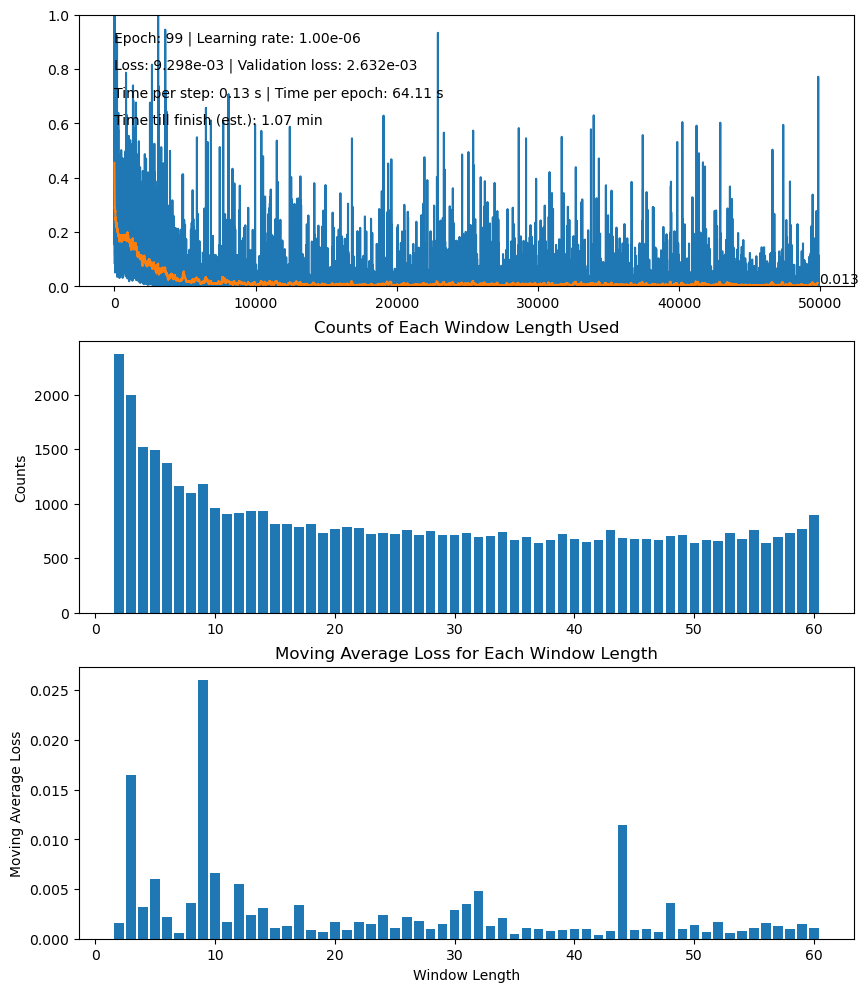

In [43]:
train(
    diffusion_imputer, 
    train_loader, 
    val_loader,
    batch_embedder = data_embedder,
    windowed_mode = True,
    window_mode = "biased_loss",
    train_on_all_every = 3,
    min_window = 2,
    max_window = 60,
    device = "cuda",
    epochs = 100,
    lr = 1e-4,
    annealing_mode = True,
    annealing_window = 5,
    annealing_multiplier = 1,
    annealing_ratio=0.75,
    annealing_minimum=1e-6,
    loss_func = diffusion_imputer.loss_func,
    validation_frequency = 2, 
    validation_prp = 1,
    verbose = False,
    plot_every = 100
    )

In [ ]:
# train_hybrid(
#     diffusion_imputer, 
#     hybrid_model,
#     train_loader, 
#     val_loader,
#     batch_embedder = embedder,
#     epochs = 20,
#     lr = 0.001, 
#     annealing_window = 5,
#     annealing_multiplier = 1,
#     loss_func = diffusion_imputer.loss_func,
#     hybrid_loss_func = hybrid_model.loss_func,
#     hybrid_start_epoch = 0,
#     hybrid_every_n_epoch = 5,
#     validation_frequency=2, 
#     validation_prp=1)

In [44]:

# save the entire model for further training
torch.save(diffusion_imputer, "diffusion_imputer_cancer_jul8.pt")
torch.save(data_embedder, "data_embedder_cancer_jul8.pt")

# Evaluation

## Chunks

In [45]:
# diffusion_imputer = torch.load("diffusion_imputer_cancer_jul5.pt")
# data_embedder = torch.load("data_embedder_cancer_jul5.pt")

In [46]:
# num_batch_test = 82
# data_loaders = get_dataloader(num_batch_test, "cuda")
# data_loader_test = get_dataloader(num_batch_test, "cuda")[2]

In [47]:
training_standard_deviation = stds['cancer_volume']
training_mean = means['cancer_volume']

training_standard_deviation
training_mean

52.43550990660676

7.734152322128005

In [48]:
test_data = test_data_counterfactuals_tensor
# test_data = test_data_factuals_tensor
# test_data = validation_data_tensor

test_data.shape

torch.Size([225456, 60, 3])

In [49]:
test_data_counterfactuals_sequence_lengths

array([ 1.,  1.,  1., ..., 59., 59., 59.])

In [50]:
#divide test data to parts based on test_data_counterfactuals_sequence_lengths (So that the stuff in each chunk is of the same length)
#row 0 of test_data_counterfactuals_sequence_lengths tells the sequence length of the first row of test_data and so on
#so, if rows 0, 5, and 19 of test_data_counterfactuals_sequence_lengths are the same, then the first, sixth, and twentieth rows of test_data are of the same length and should be in the same chunk

#find the unique sequence lengths
unique_sequence_lengths, counts = np.unique(test_data_counterfactuals_sequence_lengths, return_counts=True)
# unique_sequence_lengths, counts = np.unique(test_data_factuals_sequence_lengths, return_counts=True)
# unique_sequence_lengths, counts = np.unique(validation_data_sequence_lengths, return_counts=True)

unique_sequence_lengths
counts

#find the indices of the unique sequence lengths
indices = [np.where(test_data_counterfactuals_sequence_lengths == i)[0] for i in unique_sequence_lengths]
# indices = [np.where(test_data_factuals_sequence_lengths == i)[0] for i in unique_sequence_lengths]
# indices = [np.where(validation_data_sequence_lengths == i)[0] for i in unique_sequence_lengths]

#divide the test data into chunks based on the unique sequence lengths
test_data_chunks = [test_data[i] for i in indices]
len(test_data_chunks)
test_data_chunks[0].shape
test_data_chunks[10].shape

#cut the second dimension of each chunk to its corresponding sequence length
# test_data_chunks = [chunk[:, :int(length)+1, :] for chunk, length in zip(test_data_chunks, unique_sequence_lengths)]
test_data_chunks = [chunk[:, :int(length)+1, :] for chunk, length in zip(test_data_chunks, unique_sequence_lengths)]

test_data_chunks[0].shape
test_data_chunks[10].shape



array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59.])

array([4000, 3964, 3948, 3936, 3912, 3904, 3904, 3888, 3880, 3876, 3876,
       3876, 3868, 3868, 3864, 3860, 3852, 3852, 3852, 3848, 3848, 3844,
       3844, 3836, 3820, 3820, 3816, 3816, 3804, 3804, 3804, 3800, 3800,
       3800, 3796, 3792, 3784, 3780, 3780, 3772, 3772, 3772, 3772, 3772,
       3772, 3772, 3772, 3772, 3764, 3764, 3764, 3760, 3752, 3752, 3752,
       3748, 3748, 3744, 3744])

59

torch.Size([4000, 60, 3])

torch.Size([3876, 60, 3])

torch.Size([4000, 2, 3])

torch.Size([3876, 12, 3])

In [51]:
#copy to the gpu
test_data_chunks = [chunk.to("cuda") for chunk in test_data_chunks]

#use embedder
test_data_chunks_embedded = [data_embedder(chunk) for chunk in test_data_chunks]

#create impuation masks
imputation_masks = [diffusion_imputer.get_mask(chunk,
                                               strategy='selected_features_last_n_time') for chunk in test_data_chunks_embedded]
imputation_masks = [mask.to("cuda") for mask in imputation_masks]
imputation_masks[0]


tensor([[[0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 1.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 1.]]], device='cuda:0')

In [52]:
imputation_masks[16].shape

torch.Size([3852, 18, 3])

In [53]:
given_points = [torch.where(mask == 0, chunk, torch.tensor(float('nan')).to("cuda")) for chunk, mask in zip(test_data_chunks_embedded, imputation_masks)]
evaluated_points = [torch.where(mask != 0, chunk, torch.tensor(float('nan')).to("cuda")) for chunk, mask in zip(test_data_chunks_embedded, imputation_masks)]

given_points[58]
evaluated_points[58]

tensor([[[ 1.0806,  0.3321,  3.1693],
         [ 1.0805,  0.3321,  2.8202],
         [ 1.0805,  0.3321,  2.3144],
         ...,
         [ 1.0806,  0.3321, -0.1176],
         [ 1.0805,  0.3082, -0.1388],
         [ 1.0806,  0.3321,     nan]],

        [[ 1.0806,  0.3321,  3.1693],
         [ 1.0805,  0.3321,  2.8202],
         [ 1.0805,  0.3321,  2.3144],
         ...,
         [ 1.0806,  0.3321, -0.1176],
         [ 1.0805,  0.3082, -0.1388],
         [ 1.0806,  0.3082,     nan]],

        [[ 1.0806,  0.3321,  3.1693],
         [ 1.0805,  0.3321,  2.8202],
         [ 1.0805,  0.3321,  2.3144],
         ...,
         [ 1.0806,  0.3321, -0.1176],
         [ 1.0805,  0.3082, -0.1388],
         [ 1.0805,  0.3321,     nan]],

        ...,

        [[ 1.0806,  0.3321, -0.1348],
         [ 1.0805,  0.3321, -0.1360],
         [ 1.0805,  0.3321, -0.1379],
         ...,
         [ 1.0805,  0.3321, -0.1472],
         [ 1.0806,  0.3321, -0.1472],
         [ 1.0806,  0.3082,     nan]],

        [[

tensor([[[    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan, -0.1385]],

        [[    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan, -0.1442]],

        [[    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan, -0.1397]],

        ...,

        [[    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan, -0.1474]],

        [[

In [54]:
sample_number = 20
sample_count = 100
# sample_count = test_data_chunks_embedded[0].shape[0]
samples = []
for i in range(sample_number):
    for j in range(len(test_data_chunks_embedded)):#range(58,59):
        samples.append(diffusion_imputer.eval(
            test_data_chunks_embedded[j][2000:(2000+sample_count)], imputation_masks[j][2000:(2000+sample_count)],
            mean = training_mean, std = training_standard_deviation, scale = 1
            ),
            )
        progress = (i * len(test_data_chunks_embedded) + j) / (sample_number * len(test_data_chunks_embedded))      
        print(f"Progress: {progress * 100:.2f}%")
        print(j)

max difference =  21.409988403320312
data at max difference =  2.8340299129486084
imputed at max difference =  24.2440185546875
mae =  0.5998466610908508
rmse =  11.389292841372283
Progress: 0.00%
0
max difference =  43.69564437866211
data at max difference =  2.3850014209747314
imputed at max difference =  46.08064651489258
mae =  0.7600550055503845
rmse =  20.42264457370924
Progress: 0.08%
1
max difference =  5.255807399749756
data at max difference =  5.496946334838867
imputed at max difference =  0.24113886058330536
mae =  0.31585174798965454
rmse =  4.106155727220618
Progress: 0.17%
2
max difference =  55.33047103881836
data at max difference =  5.049139499664307
imputed at max difference =  60.37961196899414
mae =  1.2920444011688232
rmse =  31.88708761463995
Progress: 0.25%
3
max difference =  88.54277801513672
data at max difference =  12.65227222442627
imputed at max difference =  101.19505310058594
mae =  3.7997961044311523
rmse =  70.00583283797555
Progress: 0.34%
4
max diff

In [55]:
len(samples)

1180

In [56]:
#save the samples
torch.save(samples, "samples_cancer_jul8.pt")

In [61]:
# samples = torch.load("samples_cancer_jun3.pt")

In [57]:
# imputation_results = [samples[i][0] for i in range(len(samples))] # = imputation results, input data, mask, mae
# imputation_results = torch.stack(imputation_results, dim = 0)

In [58]:
target_column = 2

In [59]:
samples[0][0][:, -1, target_column]
samples[1][0][:, -1, target_column]

tensor([-1.4434e-01, -1.3843e-01, -1.3674e-01, -1.4563e-01, -1.4054e-01,
        -1.4305e-01, -1.4281e-01, -1.4529e-01, -1.2997e-01, -1.3473e-01,
        -1.3508e-01, -1.3162e-01, -1.4739e-01, -1.4892e-01, -1.4796e-01,
        -1.5867e-01,  2.4244e+01,  1.4086e-01,  5.0397e+00,  1.4106e+00,
        -1.4407e-01, -1.4659e-01, -1.3905e-01, -1.4908e-01,  2.5593e-01,
         5.5878e-01,  3.2165e-01,  5.2567e-01, -1.4153e-01, -1.3596e-01,
        -1.3673e-01, -1.4924e-01, -1.4659e-01, -1.4778e-01, -1.4713e-01,
        -1.5064e-01, -3.3583e-02,  1.0531e+00,  2.6631e-01,  1.2742e+00,
        -1.8855e-02,  1.0403e-01,  3.2683e-02,  1.3174e-01,  5.2804e+00,
         1.5490e+00, -1.0785e-01,  6.8113e-01, -9.8129e-02, -8.0722e-02,
        -9.2097e-02, -8.3560e-02, -1.1300e-01, -1.3604e-01, -1.3051e-01,
        -1.3581e-01, -1.4640e-01, -1.4805e-01, -1.4267e-01, -1.4966e-01,
        -1.4139e-01, -1.5513e-01, -1.3492e-01, -1.4873e-01, -1.4748e-01,
        -1.5162e-01, -1.5759e-01, -1.5194e-01, -1.4

tensor([-1.4814e-01, -1.4660e-01, -1.5451e-01, -1.5383e-01,  4.9978e-01,
         3.2893e-02,  4.4637e-01,  3.7186e-01, -1.4314e-01, -1.4616e-01,
        -1.4493e-01, -1.4590e-01,  4.9769e-01,  6.8487e-01,  1.9441e-01,
         6.0583e-01, -1.3968e-01, -1.3831e-01, -1.3860e-01, -1.4252e-01,
        -1.4677e-01, -1.5247e-01, -1.4816e-01, -1.4996e-01, -3.1544e-02,
         1.3993e+00,  1.2405e+00,  1.1265e+00,  9.4042e-02,  1.3601e-01,
         7.2094e-02,  1.1442e-01,  2.2693e+00,  4.2628e+00,  1.1443e+01,
         4.6081e+01, -8.2069e-02, -8.6471e-02, -8.2722e-02, -8.9336e-02,
        -1.2926e-01, -1.3095e-01, -1.2998e-01, -1.3296e-01, -1.5233e-01,
        -1.4545e-01, -1.3960e-01, -1.4798e-01, -1.4740e-01, -1.4607e-01,
        -1.4601e-01, -1.4754e-01, -1.5091e-01, -1.4699e-01, -1.4719e-01,
        -1.4987e-01, -1.4476e-01, -1.4403e-01, -1.4736e-01, -1.4749e-01,
        -1.1065e-01, -1.1317e-01, -1.1040e-01, -1.1611e-01, -1.4737e-01,
        -1.4862e-01, -1.4766e-01, -1.4912e-01, -5.9

In [60]:
imputation_results = [samples[i][0][:, -1, target_column] for i in range(len(samples))] # = imputation results, input data, mask, mae
imputation_results = torch.cat(imputation_results, dim = 0)
imputation_results_denormed = imputation_results * training_standard_deviation + training_mean
imputation_results_denormed = imputation_results_denormed.reshape(sample_number, sample_count, -1)
# imputation_results_denormed
imputation_results_denormed.shape

torch.Size([20, 100, 59])

In [61]:
# imputation_results = [samples[i][0] for i in range(len(samples))] # = imputation results, input data, mask, mae
# imputation_results = torch.stack(imputation_results, dim = 0)

In [62]:
denormed_data = [samples[i][1][:, -1, target_column] for i in range(len(samples))] # = imputation results, input data, mask, mae
denormed_data = torch.cat(denormed_data, dim = 0)
denormed_data = denormed_data * training_standard_deviation + training_mean
denormed_data = denormed_data.reshape(sample_number, sample_count, -1)
denormed_data = denormed_data[0]
denormed_data.shape

torch.Size([100, 59])

In [63]:
# imputation_results_denormed[0]
# imputation_results_denormed[1]
# denormed_data = imputation_results_denormed[1]
# imputation_results_denormed = imputation_results_denormed[0]


In [64]:
# imputation_mask = [samples[i][2][:, -1, 2] for i in range(len(samples))]
# imputation_mask = torch.cat(imputation_mask, dim = 0)
# imputation_mask

In [65]:
# denormed_data = test_data_chunks[16] * training_standard_deviation + training_mean
# denormed_data = denormed_data.cpu().detach()

# given_points = given_points.cpu().detach()
# eval_points = eval_points.cpu().detach()

In [66]:
# qlist = [0.05, 0.25, 0.50, 0.75, 0.95]
# #qlist = [0.5]
# quantiles_imp = []
# for q in qlist:
#     quantiles = torch.quantile(imputation_results_denormed, q, dim=0, interpolation="linear")
#     quantiles_imp.append(quantiles)

# means = torch.mean(imputation_results_denormed, dim=0)
# quantiles_imp.append(means)

# quantiles_imp = torch.stack(quantiles_imp, dim=0).cpu()


In [67]:
qlist = [0.05, 0.25, 0.50, 0.75, 0.95]
#qlist = [0.5]
quantiles_imp = []
for q in qlist:
    quantiles = torch.quantile(imputation_results_denormed, q, dim=0, interpolation="linear")
    quantiles_imp.append(quantiles)

means = torch.mean(imputation_results_denormed, dim=0)
quantiles_imp.append(means)

quantiles_imp = torch.stack(quantiles_imp, dim=0).cpu()


In [68]:
quantiles_imp.shape

torch.Size([6, 100, 59])

In [69]:
# mae = torch.mean(torch.abs(denormed_data[imputation_masks[58].cpu() != 0] - torch.Tensor(quantiles_imp[2][imputation_masks[58].cpu() != 0]))).item()
# print(mae/1150 * 100)

In [70]:
mae = torch.mean(torch.abs(denormed_data.cpu() - torch.Tensor(quantiles_imp[2].cpu()))).item()
print(mae/1150 * 100)

2.281870468803074


In [71]:
# rmse = torch.sqrt(torch.mean((denormed_data[imputation_masks[16].cpu() != 0] - 
#                               torch.Tensor(quantiles_imp[2][imputation_masks[16].cpu() != 0]))**2)).item()
# print(rmse/1150 * 100)

In [72]:
rmse = torch.sqrt(torch.mean((denormed_data.cpu() - torch.Tensor(quantiles_imp[2].cpu()))**2)).item()
print(rmse/1150 * 100)

12.36651080587636


In [92]:
def quantile_loss(target, forecast, q: float, eval_points) -> float:
    return 2 * torch.sum(
        torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
    )


def calc_denominator(target, eval_points):
    return torch.sum(torch.abs(target * eval_points))


def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
    target = target * scaler + mean_scaler
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(forecast)):
            q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
        q_pred = torch.cat(q_pred, 0)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)


In [109]:
sample_number = 100

In [111]:
all_target = samples[0][1]  # input_data same for all samples (B, L, K)
all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, training_mean, training_standard_deviation)
print(CRPS)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
quantiles_imp.shape

torch.Size([6, 1000, 60, 3])

In [74]:
L = test_data.shape[1]
K = test_data.shape[2]

dataind = 40  # Number of samples to visualize
start_time = 40 
n_skip = 0  # Number of columns to skip

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=dataind, ncols=K - n_skip, figsize=(24.0, 6 * dataind))

for i in range(dataind):
    for k in range(n_skip, K):  # Start from n_skip instead of 0
        df = pd.DataFrame({
            "x": np.arange(start_time, L),
            "val": denormed_data[i, start_time:, k],
            "y": eval_points[i, start_time:, k]
        })
        df = df[df.y != 0]
        df2 = pd.DataFrame({
            "x": np.arange(start_time, L),
            "val": denormed_data[i, start_time:, k],
            "y": given_points[i, start_time:, k]
        })
        df2 = df2[df2.y != 0]
        indices = df.x.astype(int).to_numpy()
        row = i
        col = k - n_skip  # Adjust column index for skipped columns

        axes[row][col].plot(range(start_time, L), quantiles_imp[2][i, start_time:, k], color='g', linestyle='solid', label='median')
        axes[row][col].fill_between(range(start_time, L), quantiles_imp[0][i, start_time:, k], quantiles_imp[4][i, start_time:, k], color='g', alpha=0.3)
        axes[row][col].plot(df.x, df.val, color='b', marker='o', linestyle='None')
        axes[row][col].plot(df.x, quantiles_imp[5][i, indices, k], color='r', linestyle='None', label='median', marker='x')
        axes[row][col].plot(df.x, quantiles_imp[0][i, indices, k], color='r', linestyle='None', marker=1)
        axes[row][col].plot(df.x, quantiles_imp[4][i, indices, k], color='r', linestyle='None', marker=1)

        if col == 0:  # Only label the first of the remaining columns
            axes[row][col].set_ylabel('Value')
        if row == dataind - 1:  # Only label the last row
            axes[row][col].set_xlabel('Time')

# Optional: Adjust the layout for better spacing
plt.tight_layout()
plt.show()


IndexError: too many indices for tensor of dimension 2

Error in callback <function flush_figures at 0x2b955f7ad990> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 